<a href="https://colab.research.google.com/github/Leerish/Deep-Learning-Milestone-Projects/blob/main/SkimLit_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: Skimlit

Build a NLP model to make reading medical abstracts easier.

## Get Data

Since we will be replicating the paper (PubMed 200k RCT):https://arxiv.org/abs/1710.06071

Download the data from github : https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
! git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 13.91 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
# Check files in PubMed_20K dataset

!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# Starting Experimentation using 20k dataset with numbers replaced with "@" sign

data_dir ="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all filenames in target directory
import os

filenames =[data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

 ## Preprocess data

One of the best ways is to visualize the data , So let's create a function to visualize the data

In [ ]:
# Create Function to read lines of a document

def get_lines(filename):
  """
  Reads a file and return the lines of text as a list

  Args:
    Filename : a string containing the target filepath
  Returns:
    A list of strings with one string per line from target filename
  """

  with open(filename ,"r") as f:
    return f.readlines()


In [ ]:
train_lines = get_lines(data_dir +"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

Let's think about how we want our data want to look like ..

```
[{'line_number' : 0,
   'target': 'BACKGROUND',
   'text':'Sample Sentence',
   'total_lines':11}]
```

Lets create a function to turn our data like this

In [ ]:
def preprocess_data(filename):
    """
    Returns a list of dictionaries of abstract line data.

    Takes in Filename, reads its contents and sorts through each line,
    extracting things like the target label, the text of the sentence,
    how many sentences are in the current abstract, and what sentence number the target line is.
    """

    input_lines = get_lines(filename)  # Get lines from the filename
    abstract_lines = ""  # Create an empty abstract
    abstract_samples = []  # Create an empty list of abstracts

    # Loop through each line in the target file
    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = ""  # Reset the abstract string if the line is an ID line
        elif line.isspace():  # Check whether the line is a new line
            abstract_line_split = abstract_lines.splitlines()

            # Iterate through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split("\t")  # Split target label from text
                line_data["target"] = target_text_split[0]  # target label
                line_data["text"] = target_text_split[1].lower()  # get target text and lower it
                line_data["line_number"] = abstract_line_number  # Number in which the line appears in abstract
                line_data["total_lines"] = len(abstract_line_split) - 1  # how many lines are there in the target abstract
                abstract_samples.append(line_data)
        else:  # if the above conditions aren't fulfilled, the line contains a labeled sentence
            abstract_lines += line

    return abstract_samples


In [ ]:
train_samples = preprocess_data(data_dir +"train.txt")
val_samples = preprocess_data(data_dir +"dev.txt")
test_samples = preprocess_data(data_dir +"test.txt")

In [ ]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Converting our data into DataFrame using Pandas

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(12)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labels in training data

train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

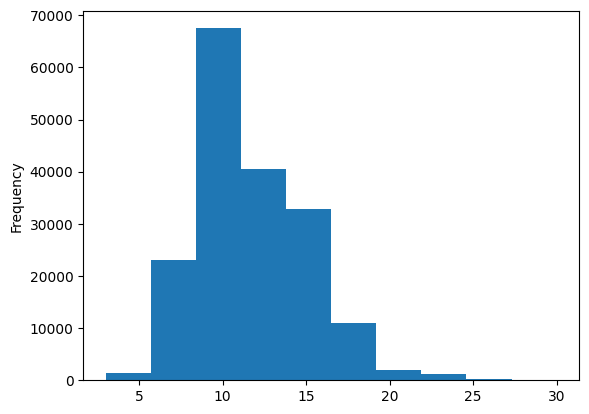

In [ ]:
# Let's check the length of different lines

train_df.total_lines.plot.hist();

### Get list of sentences

In [ ]:
# Convert abstract text lines into lists

train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()


In [ ]:
# View first 10 lines of training data
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

##Make Numeric Labels (Model Requires numeric labels)




In [ ]:
# One Hot Encode labels

from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse = False)
train_labels = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))
train_labels

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [ ]:
# Extract labels ("target" columns) and encode them into integers

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_label_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
test_label_encoded = label_encoder.transform(test_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())

# Check train labels
train_label_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes , class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [ ]:
import tensorflow as tf

tf.constant(train_labels)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

# Series of Modelling Experiments

BaseLine Model - TF-IDF Multinomial Naive Bayes Classifier


In [ ]:
## Model 0: Building a Baseline Model

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf" , TfidfVectorizer()),
    ("clf" , MultinomialNB())
])

# Fit the pipeline to training data

model_0.fit(X =train_sentences,
            y=train_label_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model
model_0.score(X= val_sentences ,
                 y = val_labels_encoded )

0.7218323844829869

In [ ]:
# Make Predictions

baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
# Importing Helper Functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-12-12 16:05:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-12 16:05:14 (112 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results

baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

NameError: ignored

## Preparing our data for deep sequence models

We need to vectorize and embed the data

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
sent_len = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_len)
avg_sent_len

26.338269273494777

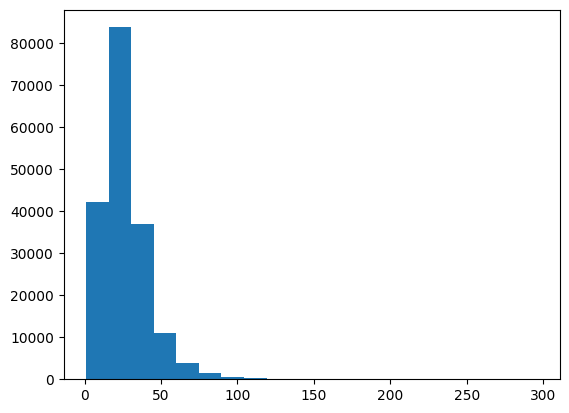

In [ ]:
# Data Distribution

import matplotlib.pyplot as plt
plt.hist(sent_len , bins = 20);

In [ ]:
# What is the most maximum length of sentences in our data?
output_seq_len = int(np.percentile(sent_len , 95))
output_seq_len

55

In [ ]:
# Maximum Sequence length
max(sent_len)

296

### Create text vectorizer layer

Turning our text into numbers

In [ ]:
# How many words are in our vocab ?
max_tokens = 68000


In [ ]:
# Create text vectorizer

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens ,
                                    output_sequence_length = output_seq_len,)

In [ ]:
# Adapt text vectorizer to training sentences

text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer in random sentences

import random

target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text:{len(target_sentence)}")
print(f"\nVectorized Text:{text_vectorizer([target_sentence])}")

Text:
a double-blinded randomized study was performed to assess whether intra-alveolar administration of chx decreases ao .

Length of text:117

Vectorized Text:[[    8  1675    29    17    10   153     6   216   180 30630   288     4
   6116  1073  5685     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# How many words in training vocabulary

rct_20K_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab:{len(rct_20K_vocab)}")
print(f"Most Common words:{rct_20K_vocab[:5]}")
print(f"Least Common words in vocab:{rct_20K_vocab[-5:]}")

Number of words in vocab:64841
Most Common words:['', '[UNK]', 'the', 'and', 'of']
Least Common words in vocab:['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create Custom Text Embedding


In [ ]:
# Create Token Embedding Layer
token_embed = layers.Embedding(input_dim = len(rct_20K_vocab),
                               output_dim = 128,
                               mask_zero = True,
                               name ="token_embedding")


In [ ]:
# Example

print(f"Sentence before Vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization(Before Embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded Sentence Shape:{embedded_sentence.shape}")

Sentence before Vectorization:
a double-blinded randomized study was performed to assess whether intra-alveolar administration of chx decreases ao .

Sentence after vectorization(Before Embedding):
[[    8  1675    29    17    10   153     6   216   180 30630   288     4
   6116  1073  5685     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.00959206 -0.03207312 -0.02741301 ... -0.03316766 -0.02991577
   -0.01132854]
  [-0.00826101 -0.02935666  0.0208382  ... -0.01341263  0.01765417
    0.03284533]
  [-0.02491792  0.03406635  0.04279346 ...  0.04615319  0.02416861
    0.04512605]
  ...
  [-0.03962631 -0.01953304  0.04680189 ... -0.03089861 -0.02027122
    0.02661183]
  [-0.03962631 -0.01953304  0.04680189 ... -0.03089861 -0.02027122
    0.02661183]
  [-0.039626

## Creating Datasets (Making sure our data loads as fast as possible)

Setting up our data with tensorflow tf.data API

**Important**
Before a project read through these for preprocessing data
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [ ]:
# Turn our data into Tensorflow Datasets
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences , train_labels))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences , val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences , test_labels))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_labels.shape

(180040, 5)

In [ ]:
train_labels[0]

array([0., 0., 0., 1., 0.])

In [ ]:
# Take the TensorSliceDataset's and turn them into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

##Model 1 : Conv1D with token embeddings

In [ ]:
# Create 1D conv model
inputs = layers.Input(shape=(1,) , dtype="string")
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x= layers.Conv1D(64 , kernel_size =5 , padding="same" , activation="relu")(token_embeddings)
x =layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes , activation="softmax")(x)
model_1 = tf.keras.Model(inputs , outputs, name ="Conv1D_model")

# Compile the model
model_1.compile(loss ="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "Conv1D_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                      

In [ ]:
history_1 = model_1.fit(train_dataset,
                        steps_per_epoch =int(0.1*len(train_dataset)),
                        epochs = 3 ,
                        validation_data=valid_dataset,
                        validation_steps =int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 72s 124ms/step - loss: 0.9227 - accuracy: 0.6311 - val_loss: 0.6865 - val_accuracy: 0.7374
Epoch 2/3
562/562 [==============================] - 69s 123ms/step - loss: 0.6627 - accuracy: 0.7530 - val_loss: 0.6343 - val_accuracy: 0.7656
Epoch 3/3
562/562 [==============================] - 70s 124ms/step - loss: 0.6253 - accuracy: 0.7699 - val_loss: 0.6018 - val_accuracy: 0.7832


In [ ]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 7s 7ms/step - loss: 0.6067 - accuracy: 0.7817


[0.6067207455635071, 0.7817092537879944]

In [ ]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs , model_1_pred_probs.shape

945/945 [==============================] - 6s 7ms/step


(array([[3.79585683e-01, 1.88315928e-01, 1.18243739e-01, 2.77347177e-01,
         3.65074463e-02],
        [4.90159005e-01, 2.40694076e-01, 1.38743874e-02, 2.48980388e-01,
         6.29202556e-03],
        [1.50039315e-01, 7.74062285e-03, 1.50911289e-03, 8.40677500e-01,
         3.34742035e-05],
        ...,
        [2.12848795e-06, 8.17629800e-04, 6.06168585e-04, 1.71850877e-06,
         9.98572350e-01],
        [5.44094183e-02, 4.48551863e-01, 1.14793174e-01, 6.28807023e-02,
         3.19364816e-01],
        [1.93788707e-01, 6.07563198e-01, 3.90918292e-02, 5.69343641e-02,
         1.02621883e-01]], dtype=float32),
 (30212, 5))

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs , axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculate model_1 results

model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred =model_1_preds)

In [ ]:
model_1_results

{'accuracy': 78.17092546008209,
 'precision': 0.7781561452301451,
 'recall': 0.7817092546008209,
 'f1': 0.7789559798910622}

## Model 2: Feature Extraction with pretrained token embeddings

Now let's use pretrained word embeddings from TensorFlow Hub, more specifically Universal Sentence Encoder : https://tfhub.dev/google/universal-sentence-encoder/4

Pretrained Model used here : https://tfhub.dev/google/universal-sentence-encoder/4



In [ ]:
# Download pretrained TensorFlow Hub USE

import tensorflow_hub as hub
embedding_layer =hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                trainable=False,
                                name="universal_sentence_encoder")

In [ ]:
# Test out the pretrained embedding on a random sentence
random_sentence = random.choice(train_sentences)
print(f"Random Sentence:\n{random_sentence}")
use_embedding_layer = embedding_layer([random_sentence])
print(f"After Embedding:{use_embedding_layer[0][:30]}")

Random Sentence:
salsalate increased insulin auc by @ % ( p = @ ) and homa-b by @ % ( p < @ ) while estimates of insulin sensitivity/resistance were unaffected .
After Embedding:[-0.01820558 -0.00641318  0.02159151 -0.0505954   0.00142217  0.03956005
  0.03800938 -0.04109487  0.05678971  0.06451228  0.08137225 -0.02008939
  0.01011793  0.01879439 -0.01556959 -0.06558184 -0.08200072  0.04445775
 -0.02362362 -0.03847487  0.05279445  0.051522    0.02909695  0.02689776
  0.07522638  0.06374376  0.03461473  0.03590563 -0.03369376 -0.06345563]


## Model 2: Building and Fitting a NLP feature Extraction model using pretrained embeddings


In [ ]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax", name="output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs, name="USE_model")

# Compile the model
model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]  # Corrected the metric name to "accuracy"
)


In [ ]:
model_2.summary()

Model: "USE_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 output_layer (Dense)        (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Fit the data
history_2 = model_2.fit(train_dataset,
                        steps_per_epoch =int(0.1*len(train_dataset)),
                        epochs = 3 ,
                        validation_data=valid_dataset,
                        validation_steps =int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 18ms/step - loss: 0.9167 - accuracy: 0.6519 - val_loss: 0.7974 - val_accuracy: 0.6908
Epoch 2/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7694 - accuracy: 0.7018 - val_loss: 0.7553 - val_accuracy: 0.7048
Epoch 3/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7519 - accuracy: 0.7128 - val_loss: 0.7381 - val_accuracy: 0.7151


In [ ]:
# Evaluate on whole dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.7409 - accuracy: 0.7141


[0.7409238219261169, 0.7140871286392212]

In [ ]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 14s 14ms/step


array([[4.3093163e-01, 3.5539529e-01, 2.1547114e-03, 2.0098478e-01,
        1.0533517e-02],
       [3.7663522e-01, 4.6773744e-01, 4.2248857e-03, 1.4839810e-01,
        3.0043975e-03],
       [2.1824682e-01, 1.4647813e-01, 1.6526973e-02, 5.7713968e-01,
        4.1608442e-02],
       ...,
       [1.7439326e-03, 5.3420551e-03, 4.7057185e-02, 6.3260313e-04,
        9.4522423e-01],
       [4.7234823e-03, 4.8032068e-02, 2.0234047e-01, 1.4279817e-03,
        7.4347603e-01],
       [1.3995630e-01, 2.9174379e-01, 4.9638361e-01, 7.3550823e-03,
        6.4561173e-02]], dtype=float32)

In [ ]:
# Convert the predictionprobabilities found with feature extraction model
model_2_preds = tf.argmax(model_2_pred_probs , axis =1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
#calculate results

calculate_results(y_true = val_labels_encoded ,
                  y_pred = model_2_preds)

{'accuracy': 71.40871177015755,
 'precision': 0.7143973444153947,
 'recall': 0.7140871177015755,
 'f1': 0.7112238226866214}

## Model 3: Conv1D with character embeddings

### Creating Character level tokenizer

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
# Make function to split sentences into characters

def split_char(text):
  return " ".join(list(text))

# Text Splitting non-character-level sequence into characters
split_char(random_sentence)

's a l s a l a t e   i n c r e a s e d   i n s u l i n   a u c   b y   @   %   (   p   =   @   )   a n d   h o m a - b   b y   @   %   (   p   <   @   )   w h i l e   e s t i m a t e s   o f   i n s u l i n   s e n s i t i v i t y / r e s i s t a n c e   w e r e   u n a f f e c t e d   .'

In [ ]:
" ".join(list("LEERISH"))

'L E E R I S H'

In [ ]:
train_chars =[split_char(sentence) for sentence in train_sentences]
val_chars =[split_char(sentence) for sentence in val_sentences]
test_chars =[split_char(sentence) for sentence in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# Average Character Length

char_lens =[len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

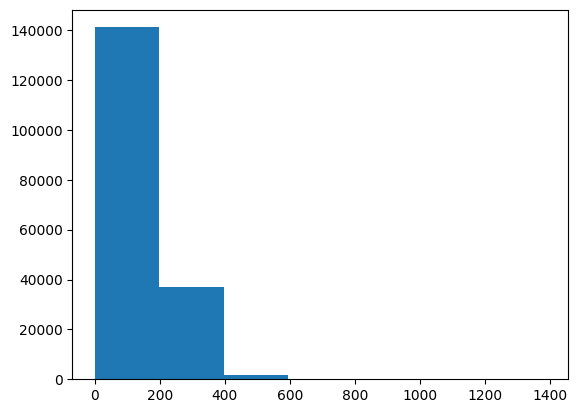

In [ ]:
# Check Distribution
import matplotlib.pyplot as plt
plt.hist(char_lens , bins =7);

In [ ]:
# Find the most char length
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all Keyboard Characters
import string

alpha = string.ascii_lowercase+string.digits+string.punctuation
alpha

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance

NUM_CHAR_TOKENS = len(alpha) + 2 # add 2 for space and oov token
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    #standardize="lower_and_strip_punctuation", # Set to none if you want to leave punctuations
                                    name ="char_vectorizer")

In [ ]:
random.choice(train_sentences)

'the @ of @ ( @ % ) weak patients not matchable to not-weak patients had even worse prognosis and higher costs .'

In [ ]:
# Adapt vectorizer to data

char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats

char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab:{len(char_vocab)}")
print(f"5 Most Common Characters:{char_vocab[:5]}")
print(f"Print least common characters:{char_vocab[-5:]}")


Number of different characters in character vocab:28
5 Most Common Characters:['', '[UNK]', 'e', 't', 'i']
Print least common characters:['k', 'x', 'z', 'q', 'j']


In [ ]:
random_train_chars = random.choice(train_chars)
vectorized_chars = char_vectorizer([random_train_chars])
vectorized_chars

<tf.Tensor: shape=(1, 290), dtype=int64, numpy=
array([[12,  4,  6,  2,  5,  8,  5,  6, 10, 22,  4,  6,  7, 15,  4,  5,
        12,  8,  2, 18,  8,  2,  9,  9,  4,  7,  6, 15,  7, 10,  2, 12,
         9, 20,  2,  8,  2, 16,  9,  2, 10,  3,  7,  2, 21,  5, 12, 16,
         5,  3,  2,  3, 13,  2,  2, 17, 17,  2, 11,  3,  9,  7, 17, 17,
         2, 14, 15,  7,  6,  4,  8,  7,  6,  9,  3,  5,  3, 16,  9,  5,
         6, 10,  4,  6, 11,  4, 10,  2,  6, 11,  2,  7, 17,  5,  6,  2,
        15,  4,  5,  5,  6, 10,  4,  8,  7,  6, 10,  2, 17,  4, 11,  4,
         2,  6, 11, 19, 11,  7, 15, 14,  5,  8,  2, 10, 20,  4,  3, 13,
        11,  7,  6,  3,  8,  7, 12, 14, 15,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0, 

###Creating Character Level Embedding


In [ ]:
# Creating char embedding layer
char_embed =layers.Embedding(input_dim = len(char_vocab),
                             output_dim =25,
                             mask_zero = True,
                             name="char_embed")

In [ ]:
# Test our Character Embedding layer
print(f"Charified Text:\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"After Embedding and vectorization:{char_embed_example}")
print(char_embed_example.shape)

Charified Text:
l i n e a r   a n d   b i n o m i a l   r e g r e s s i o n   m o d e l s   w e r e   u s e d   t o   e v a l u a t e   t h e   e f f e c t s   o f   f e - p m   o n   i r o n   s t a t u s   a n d   i n c i d e n c e   o f   a n e m i a   a n d   i r o n   d e f i c i e n c y   ,   c o m p a r e d   w i t h   c o n t r o l - p m   .

After Embedding and vectorization:[[[-0.04281224 -0.02148905 -0.03674346 ...  0.04866383 -0.04492202
   -0.01367514]
  [ 0.03451807 -0.04519885  0.03900296 ...  0.03638024  0.03220483
    0.00240598]
  [ 0.03243369  0.01103957 -0.02293791 ...  0.03004369 -0.04512529
    0.04722489]
  ...
  [ 0.03998674  0.03941    -0.01502184 ... -0.03882117  0.0386294
    0.00227984]
  [ 0.03998674  0.03941    -0.01502184 ... -0.03882117  0.0386294
    0.00227984]
  [ 0.03998674  0.03941    -0.01502184 ... -0.03882117  0.0386294
    0.00227984]]]
(1, 290, 25)


### Building a Conv1D model to fit on character embeddings

In [ ]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,) , dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embedding = char_embed(char_vectors)
x = layers.Conv1D(65,
                  kernel_size = 5,
                  padding="same",
                  activation="relu")(char_embedding)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes , activation ="softmax")(x)
model_3 = tf.keras.Model(inputs , outputs , name="char_conv1D")

# Compile the model

model_3.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
model_3.summary()

Model: "char_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d (Conv1D)             (None, 290, 65)           8190      
                                                                 
 global_max_pooling1d (Glob  (None, 65)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 5)                 

In [ ]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars , train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars , val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars , test_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model
history_3 = model_3.fit(train_char_dataset,
                        steps_per_epoch = int(0.1*len(train_char_dataset)),
                        epochs=3,
                        validation_data=val_char_dataset,
                        validation_steps=int(0.1*len(val_char_dataset)))


Epoch 1/3
562/562 [==============================] - 16s 26ms/step - loss: 1.2598 - accuracy: 0.4798 - val_loss: 1.1387 - val_accuracy: 0.5399
Epoch 2/3
562/562 [==============================] - 20s 36ms/step - loss: 1.0930 - accuracy: 0.5534 - val_loss: 1.0187 - val_accuracy: 0.5851
Epoch 3/3
562/562 [==============================] - 15s 27ms/step - loss: 0.9963 - accuracy: 0.6038 - val_loss: 0.9417 - val_accuracy: 0.6273


In [ ]:
# Make Predictions

model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 9s 9ms/step


In [ ]:
# Prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs , axis =1 )
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 3, 3, ..., 4, 2, 1])>

In [ ]:
result_3 = calculate_results(y_true=val_labels_encoded,
                  y_pred = model_3_preds)
result_3

{'accuracy': 62.703561498742225,
 'precision': 0.632821853597045,
 'recall': 0.6270356149874222,
 'f1': 0.6144142664164141}

## Model 4: Combining pretrained token embedding + characters embeddings(hybrid embedding layer)

1. Create a token level embedding model
2. Create a character-level model
3. Combine 1 and 2 with concatenate
4. Build a series of output layers on top of 3
5. construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [ ]:
# 1. Setup token inputs / Model

token_inputs = layers.Input(shape=[] ,dtype=tf.string)
token_embeddings = embedding_layer(token_inputs)
token_output = layers.Dense(128 , activation = "relu")(token_embeddings)
token_model=tf.keras.Model(token_inputs,
                           token_output)

# 2. Setup Char Inputs / Model

char_inputs = layers.Input(shape=(1,) , dtype =tf.string , name ="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(char_inputs , char_bi_lstm)

# 3. Concatenate token and char inputs ( create hybrid token embedding)
token_char_concat = layers.Concatenate(name ="token_char_layer")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in dropout , discussed in section 4.2 of paper attached in begining

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combine_dense = layers.Dense(128 , activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combine_dense)
output_layer = layers.Dense(num_classes , activation="softmax")(final_dropout)

model_4 = tf.keras.Model(inputs=[token_model.input , char_model.input],
                         outputs=output_layer,
                         name="hybrid_model")



In [ ]:
model_4.summary()

Model: "hybrid_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['input_3[0][0]']  

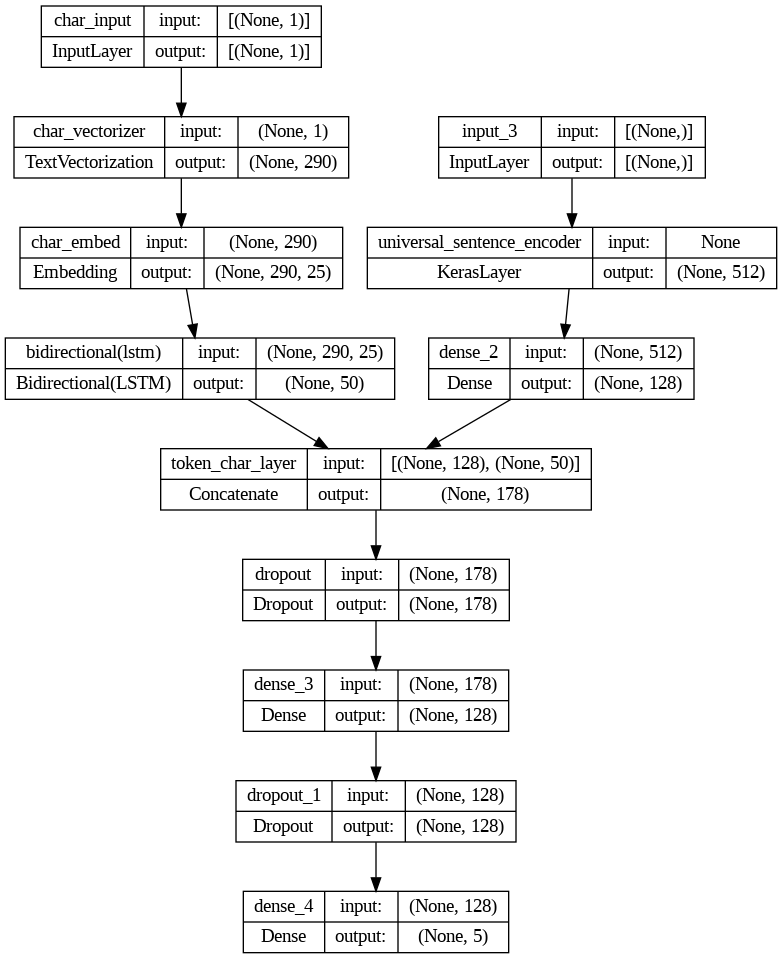

In [ ]:
# Plot hybrid token and character model

from keras.utils import plot_model

plot_model(model_4 , show_shapes = True)

In [ ]:
# Compile the model

model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Combining token and character data into a tf.data Dataset

In [ ]:
#Training Dataset
train_token_char_data =tf.data.Dataset.from_tensor_slices((train_sentences , train_chars))
train_char_token_labels =tf.data.Dataset.from_tensor_slices(train_labels)
train_char_token_dataset = tf.data.Dataset.zip((train_token_char_data , train_char_token_labels ))
# Batching and prefetching
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Validation Dataset
#Training Dataset
val_token_char_data =tf.data.Dataset.from_tensor_slices((val_sentences , val_chars))
val_char_token_labels =tf.data.Dataset.from_tensor_slices(val_labels)
val_char_token_dataset = tf.data.Dataset.zip((val_token_char_data , val_char_token_labels ))
# Batching and prefetching
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_dataset , val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting our model



In [ ]:
history_4 = model_4.fit(train_char_token_dataset,
                        steps_per_epoch =int(0.1*len(train_char_token_dataset)),
                        epochs = 3,
                        validation_data = val_char_token_dataset,
                        validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 192s 319ms/step - loss: 0.9806 - accuracy: 0.6085 - val_loss: 0.7738 - val_accuracy: 0.6981
Epoch 2/3
562/562 [==============================] - 186s 332ms/step - loss: 0.7977 - accuracy: 0.6937 - val_loss: 0.7150 - val_accuracy: 0.7254
Epoch 3/3
562/562 [==============================] - 176s 313ms/step - loss: 0.7737 - accuracy: 0.7033 - val_loss: 0.6912 - val_accuracy: 0.7434


In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 64s 68ms/step - loss: 0.6960 - accuracy: 0.7333


[0.6959517598152161, 0.7332847714424133]

In [ ]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 76s 76ms/step


array([[4.4227889e-01, 3.3613089e-01, 4.9488922e-03, 2.1144043e-01,
        5.2008452e-03],
       [3.8527837e-01, 3.5068521e-01, 2.6233641e-03, 2.6038229e-01,
        1.0308076e-03],
       [3.3137593e-01, 1.6587330e-01, 3.1002026e-02, 4.4817987e-01,
        2.3568913e-02],
       ...,
       [4.1464888e-04, 8.7159043e-03, 4.5181632e-02, 2.1617841e-04,
        9.4547158e-01],
       [6.1011966e-03, 5.4427300e-02, 2.3346938e-01, 3.1040197e-03,
        7.0289809e-01],
       [2.5958118e-01, 3.7020621e-01, 3.0859873e-01, 2.1865238e-02,
        3.9748702e-02]], dtype=float32)

In [ ]:
model_4_preds = tf.argmax(model_4_pred_probs , axis = 1)

In [ ]:
result_4 = calculate_results(y_true = val_labels_encoded
                             ,
                             y_pred = model_4_preds)
result_4

{'accuracy': 73.32847875016549,
 'precision': 0.7328731186326007,
 'recall': 0.7332847875016549,
 'f1': 0.7303537775571189}

## Model 5: Transfer Learning with pretrained token embeddings + positional embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> **Note:** Any engineered features used to train a model should be made available during testing , Here Line Numbers and total lines are the 2 features

### Positional Embeddings

In [ ]:
# Distributions of total lines
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

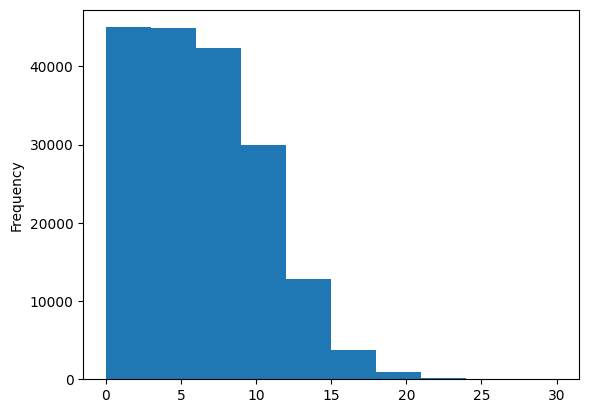

In [ ]:
train_df.line_number.plot.hist()

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number"

train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy() , depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy() , depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy() , depth=15)
train_line_numbers_one_hot[:14]  , train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

Now we've encoded our line number feature , let's do the same for total lines

In [ ]:
# Total lines

train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

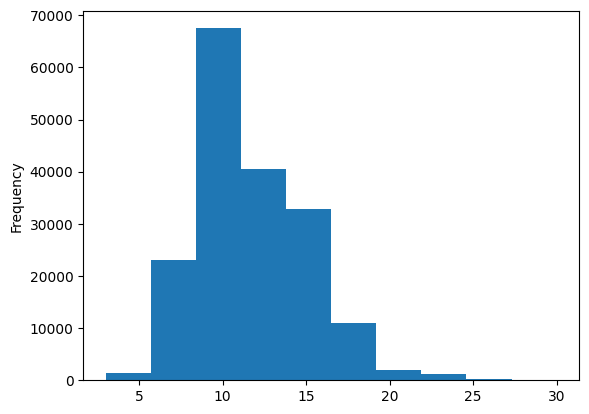

In [ ]:
# Plot them
train_df.total_lines.plot.hist()

In [ ]:
# Encode them
train_total_encode = tf.one_hot(train_df["total_lines"].to_numpy() ,depth=20)
val_total_encode = tf.one_hot(val_df["total_lines"].to_numpy() ,depth=20)
test_total_encode = tf.one_hot(test_df["total_lines"].to_numpy() ,depth=20)

### Building a tribrid embedding model

1. Create a token-level model
2. Create a Character-level model
3. Create a model for the "Line Number" Feature
4. Create a model for the "Total Line" Feature
5. Combine 1 and 2 using tf.keras.Concatenate
6. Combine the outputs of 3 , 4 ,5 layers using  tf.keras.Concatenate
7. Create a output layer
8. Combine the inputs of 1 ,2 ,3 ,4 and outputs into a tf.keras.Model

In [ ]:
# 1 .Token Inputs
token_inputs = layers.Input(shape = [] , dtype ="string" , name = "token_inputs")
token_embeddings = embedding_layer(token_inputs)
token_outputs = layers.Dense(128 , activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs=token_outputs)

# 2.Char Inputs
char_inputs = layers.Input(shape=(1 , ) , dtype="string" , name="char_inputs")
char_vectors= char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs ,
                            outputs=char_bi_lstm)

# 3.Line Numbers
line_no_inputs = layers.Input(shape=(15,) , dtype=tf.float32 ,name="line_no")
x = layers.Dense(32, activation="relu")(line_no_inputs)
line_no_model = tf.keras.Model(inputs=line_no_inputs ,
                               outputs = x)

#4.Total Line
total_lines_inputs = layers.Input(shape=(20 ,) , dtype=tf.float32 , name="total_lines")
y = layers.Dense(32 , activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs = total_lines_inputs,
                                  outputs= y)

# 5 . Combine token and char embedding into hybrid embedding
combined_embeddings = layers.Concatenate(name ="char_token_hybrid_embedding")([token_model.output,
                                                                               char_model.output])
z = layers.Dense(256 , activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings
tribid_embeddings = layers.Concatenate(name ="char_token_positional_embedding")([line_no_model.output,
                                                                                 total_line_model.output,
                                                                                 z])
# 7.Create output layer
output_layer = layers.Dense( 5 , activation ="softmax" , name ="output_layer")(tribid_embeddings)

#8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_no_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs= output_layer)


In [ ]:
model_5.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]'] 

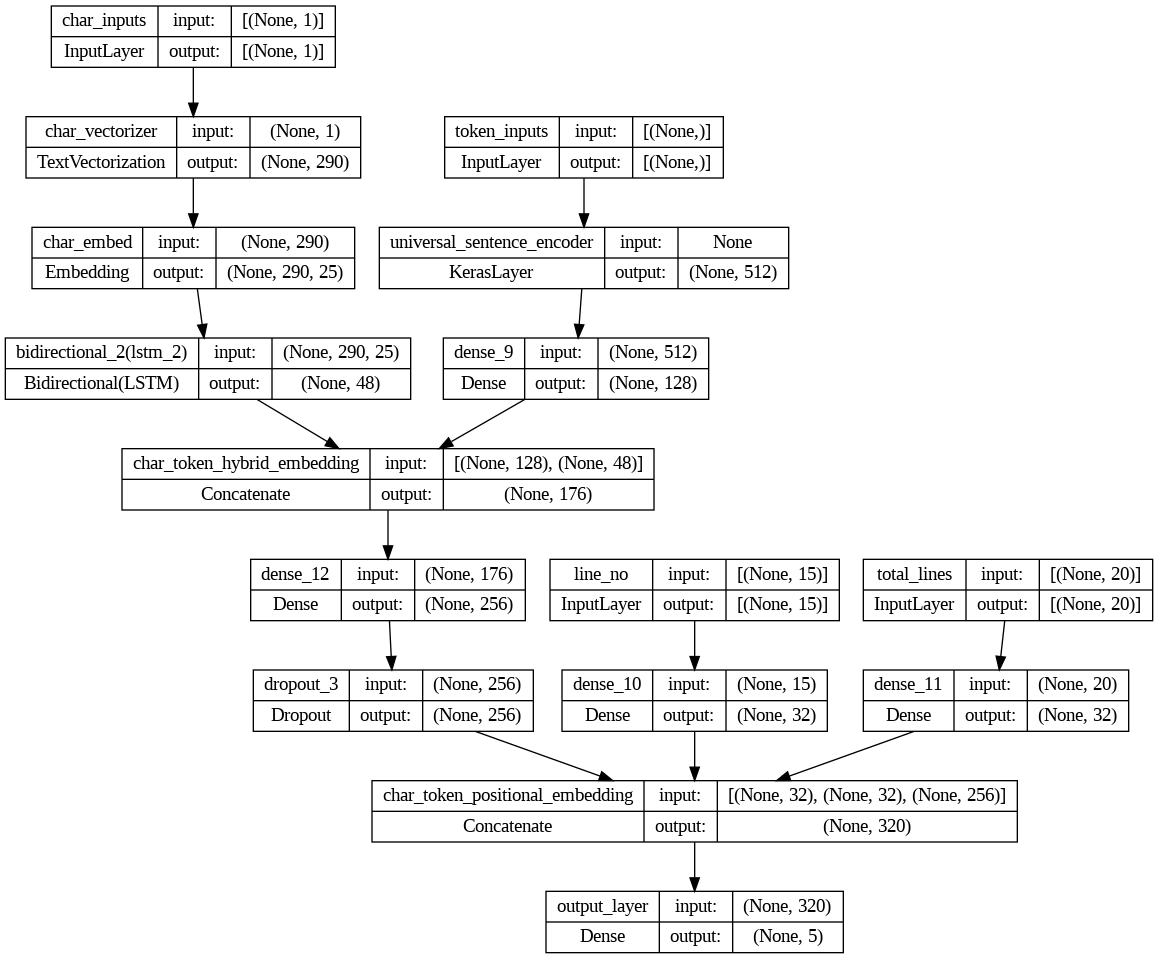

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_5 , show_shapes = True)

> What is label smoothing ?

For e.g. if our model gets too confident on a single class , it may get stuck  on that class and might ignore other classes

what label smoothing does is it **assigns some of the value from the highest pred probs to other classes , in turn  improving generalization**

In [ ]:
# Compile the model

model_5.compile(loss =tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # label smoothing helps in preventing label smoothing
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create tribid embedding datasets using tf.data


In [ ]:
# Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_encode,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels=tf.data.Dataset.from_tensor_slices(train_labels)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data,train_char_token_pos_labels ))

train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
# Same for Validation data
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_encode,
                                                                val_sentences,
                                                                val_chars))
val_char_token_pos_labels=tf.data.Dataset.from_tensor_slices(val_labels)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels ))

val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_char_token_pos_dataset ,val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting , Evaluating and making Predictions with our tribid model


In [ ]:
# Fit our tribid embedding model
history_5 = model_5.fit(train_char_token_pos_dataset,
                        steps_per_epoch = int(0.1*len(train_char_token_pos_dataset)),
                        epochs = 3,
                        validation_data = val_char_token_pos_dataset,
                        validation_steps=int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 48s 57ms/step - loss: 1.1013 - accuracy: 0.7191 - val_loss: 0.9848 - val_accuracy: 0.8035
Epoch 2/3
562/562 [==============================] - 28s 50ms/step - loss: 0.9696 - accuracy: 0.8128 - val_loss: 0.9518 - val_accuracy: 0.8185
Epoch 3/3
562/562 [==============================] - 28s 50ms/step - loss: 0.9521 - accuracy: 0.8217 - val_loss: 0.9428 - val_accuracy: 0.8271


In [ ]:
# Make Predictions
model_5_pred_probs=model_5.predict(val_char_token_pos_dataset, verbose = 1)
model_5_pred_probs

945/945 [==============================] - 30s 27ms/step


array([[0.4971153 , 0.10741825, 0.01051567, 0.36460704, 0.02034375],
       [0.51455957, 0.12053265, 0.03091324, 0.32562888, 0.00836565],
       [0.28639227, 0.134534  , 0.14496514, 0.3724065 , 0.06170199],
       ...,
       [0.03588527, 0.10911178, 0.04972948, 0.02924517, 0.7760283 ],
       [0.02958229, 0.33276904, 0.08995189, 0.0265751 , 0.5211217 ],
       [0.17462586, 0.61195153, 0.10834394, 0.04608046, 0.05899817]],
      dtype=float32)

In [ ]:
model_5_pred = tf.argmax(model_5_pred_probs , axis = 1)
model_5_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results
calculate_results(y_true = val_labels_encoded,
                  y_pred = model_5_pred)

{'accuracy': 83.04978154375745,
 'precision': 0.8295225416209343,
 'recall': 0.8304978154375745,
 'f1': 0.8294602792861114}

In [ ]:
# Saving the model

model_5.save("model_5_NLP")

In [ ]:
# Loading a model
loaded_model = tf.keras.models.load_model("model_5_NLP")

In [ ]:
l_pred_prob =loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(l_pred_prob , axis = 1)
loaded_preds[:10]

945/945 [==============================] - 28s 29ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
loaded_model_results = calculate_results(y_true = val_labels_encoded,
                                         y_pred = loaded_preds)

In [ ]:
loaded_model_results

{'accuracy': 83.04978154375745,
 'precision': 0.8295225416209343,
 'recall': 0.8304978154375745,
 'f1': 0.8294602792861114}